In [1]:
import os
os.chdir("../../../")

In [5]:
import scanpy as sc
import surgeon

In [6]:
sc.settings.set_figure_params(dpi=200)

In [7]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]

# Loading 5 Pancreas datasets and data preparation

In [8]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [9]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [10]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Train/Test Split

In [12]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [13]:
train_adata.shape, valid_adata.shape

((8235, 1000), (2059, 1000))

In [14]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

# Create & Train model with training data

In [15]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=15,
                             architecture=[512, 256, 128],
                             n_conditions=n_conditions,
                             lr=0.001,
                             eta=0.1,
                             alpha=0.01,
                             beta=100,
                             scale_factor=1.0,
                             clip_value=3.0,
                             use_batchnorm=False,
                             loss_fn='mse',
                             model_path="./models/CVAE/subsample/MMD/before-pancreas-mse-15/",
                             dropout_rate=0.0,
                             )

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 512)          513536      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None

## We assign each study to a numerical label 

In [14]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

## Training the network

In [1]:
from keras.layers import Dense, Layer

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [2]:
h = Dense(10)

In [3]:
h.get_config()

{'name': 'dense_1',
 'trainable': True,
 'units': 10,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [4]:
h = Layer()

In [5]:
h.get_config()

{'name': 'layer_1', 'trainable': True}

In [15]:
train_adata.obs[condition_key].value_counts()

Pancreas inDrop         6691
Pancreas CelSeq         1035
Pancreas Fluidigm C1     509
Name: study, dtype: int64

In [16]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=1024, 
              early_stop_limit=100,
              lr_reducer=80, 
              n_per_epoch=0,
              save=True, 
              retrain=True,
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 8235 samples, validate on 2059 samples
Epoch 1/10000
 - 1s - loss: 240.6505 - decoder_loss: 236.2313 - mmd_decoder_loss: 4.4168 - val_loss: 210.3444 - val_decoder_loss: 206.2763 - val_mmd_decoder_loss: 4.0657
Epoch 2/10000
 - 0s - loss: 198.9699 - decoder_loss: 194.0016 - mmd_decoder_loss: 4.9659 - val_loss: 184.4443 - val_decoder_loss: 179.6194 - val_mmd_decoder_loss: 4.8224
Epoch 3/10000
 - 0s - loss: 183.3493 - decoder_loss: 178.0919 - mmd_decoder_loss: 5.2550 - val_loss: 170.1595 - val_decoder_loss: 165.1319 - val_mmd_decoder_loss: 5.0251
Epoch 4/10000
 - 0s - loss: 166.4775 - decoder_loss: 160.9506 - mmd_decoder_loss: 5.5245 - val_loss: 157.1958 - val_decoder_loss: 151.1768 - val_mmd_decoder_loss: 6.0166
Epoch 5/10000
 - 0s - loss: 156.7852 - decoder_loss: 151.2682 - mmd_decoder_loss: 5.5146 - val_loss: 151.0064 - val_decoder_loss: 146.0818 - val_mmd_decoder_loss: 4.9223
Epoch 6/10000
 - 0s - loss: 150.9847 - decoder_loss: 1

In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8235 × 15 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


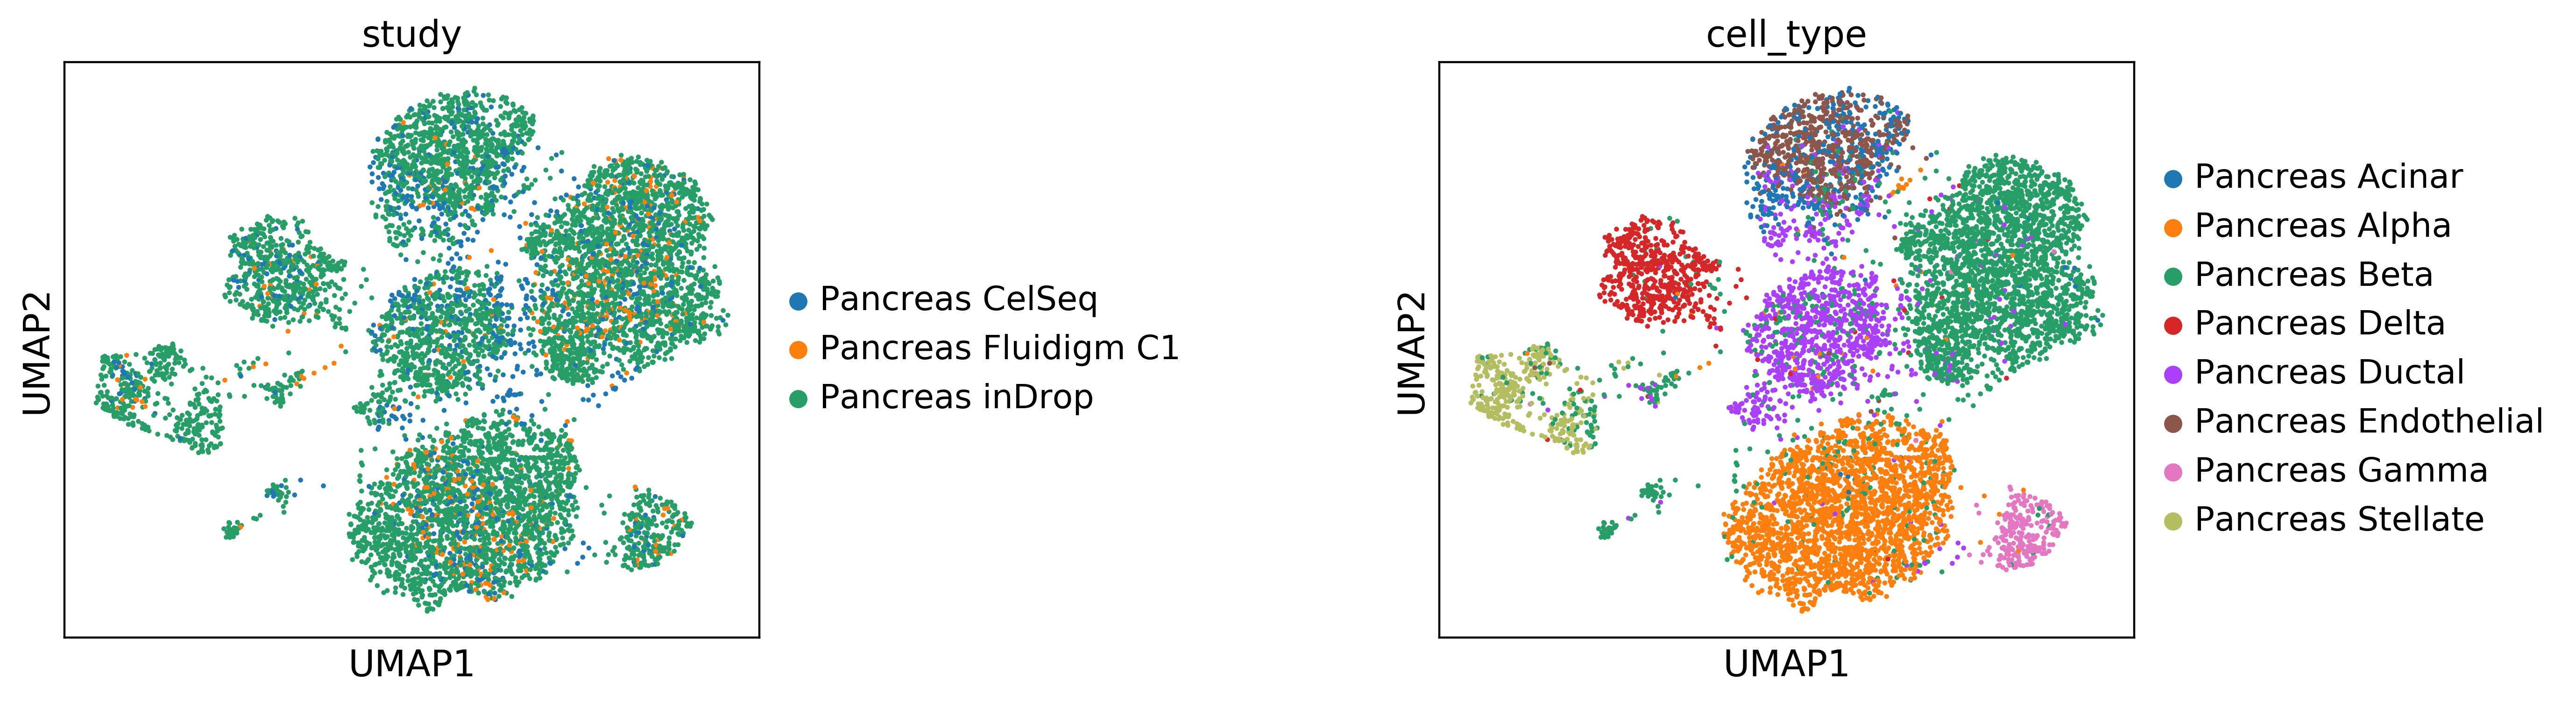

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.8)

In [21]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.3918479915119786

# Perfroming architecture Surgery

In [22]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=True, 
                              freeze_expression_input=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 512)          514560      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 512)          0           first_layer[0][0]                
__________

## Train with small new dataset containing out-of-sample condition

In [23]:
adata_out_of_sample.obs[condition_key].value_counts()

Pancreas SS2        2961
Pancreas CelSeq2    2426
Name: study, dtype: int64

In [24]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [25]:
train_adata.shape, valid_adata.shape

((4309, 1000), (1078, 1000))

In [ ]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=512, 
                  early_stop_limit=100,
                  lr_reducer=80, 
                  n_per_epoch=0,
                  save=False, 
                  retrain=True,
                  verbose=2)

Train on 4309 samples, validate on 1078 samples
Epoch 1/10000
 - 1s - loss: 111.1190 - decoder_loss: 109.6520 - mmd_decoder_loss: 1.4638 - val_loss: 109.6934 - val_decoder_loss: 108.1689 - val_mmd_decoder_loss: 1.5212
Epoch 2/10000
 - 0s - loss: 108.7856 - decoder_loss: 107.5388 - mmd_decoder_loss: 1.2436 - val_loss: 108.7237 - val_decoder_loss: 107.3608 - val_mmd_decoder_loss: 1.3597
Epoch 3/10000
 - 0s - loss: 107.8864 - decoder_loss: 106.7632 - mmd_decoder_loss: 1.1200 - val_loss: 108.0477 - val_decoder_loss: 106.7797 - val_mmd_decoder_loss: 1.2648
Epoch 4/10000
 - 0s - loss: 107.2712 - decoder_loss: 106.2178 - mmd_decoder_loss: 1.0502 - val_loss: 107.6102 - val_decoder_loss: 106.3699 - val_mmd_decoder_loss: 1.2371
Epoch 5/10000
 - 0s - loss: 106.8484 - decoder_loss: 105.7976 - mmd_decoder_loss: 1.0476 - val_loss: 107.2885 - val_decoder_loss: 106.0351 - val_mmd_decoder_loss: 1.2501
Epoch 6/10000
 - 0s - loss: 106.4799 - decoder_loss: 105.4268 - mmd_decoder_loss: 1.0499 - val_loss: 1

In [29]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(5387, 1)

In [30]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 5387 × 20 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [31]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

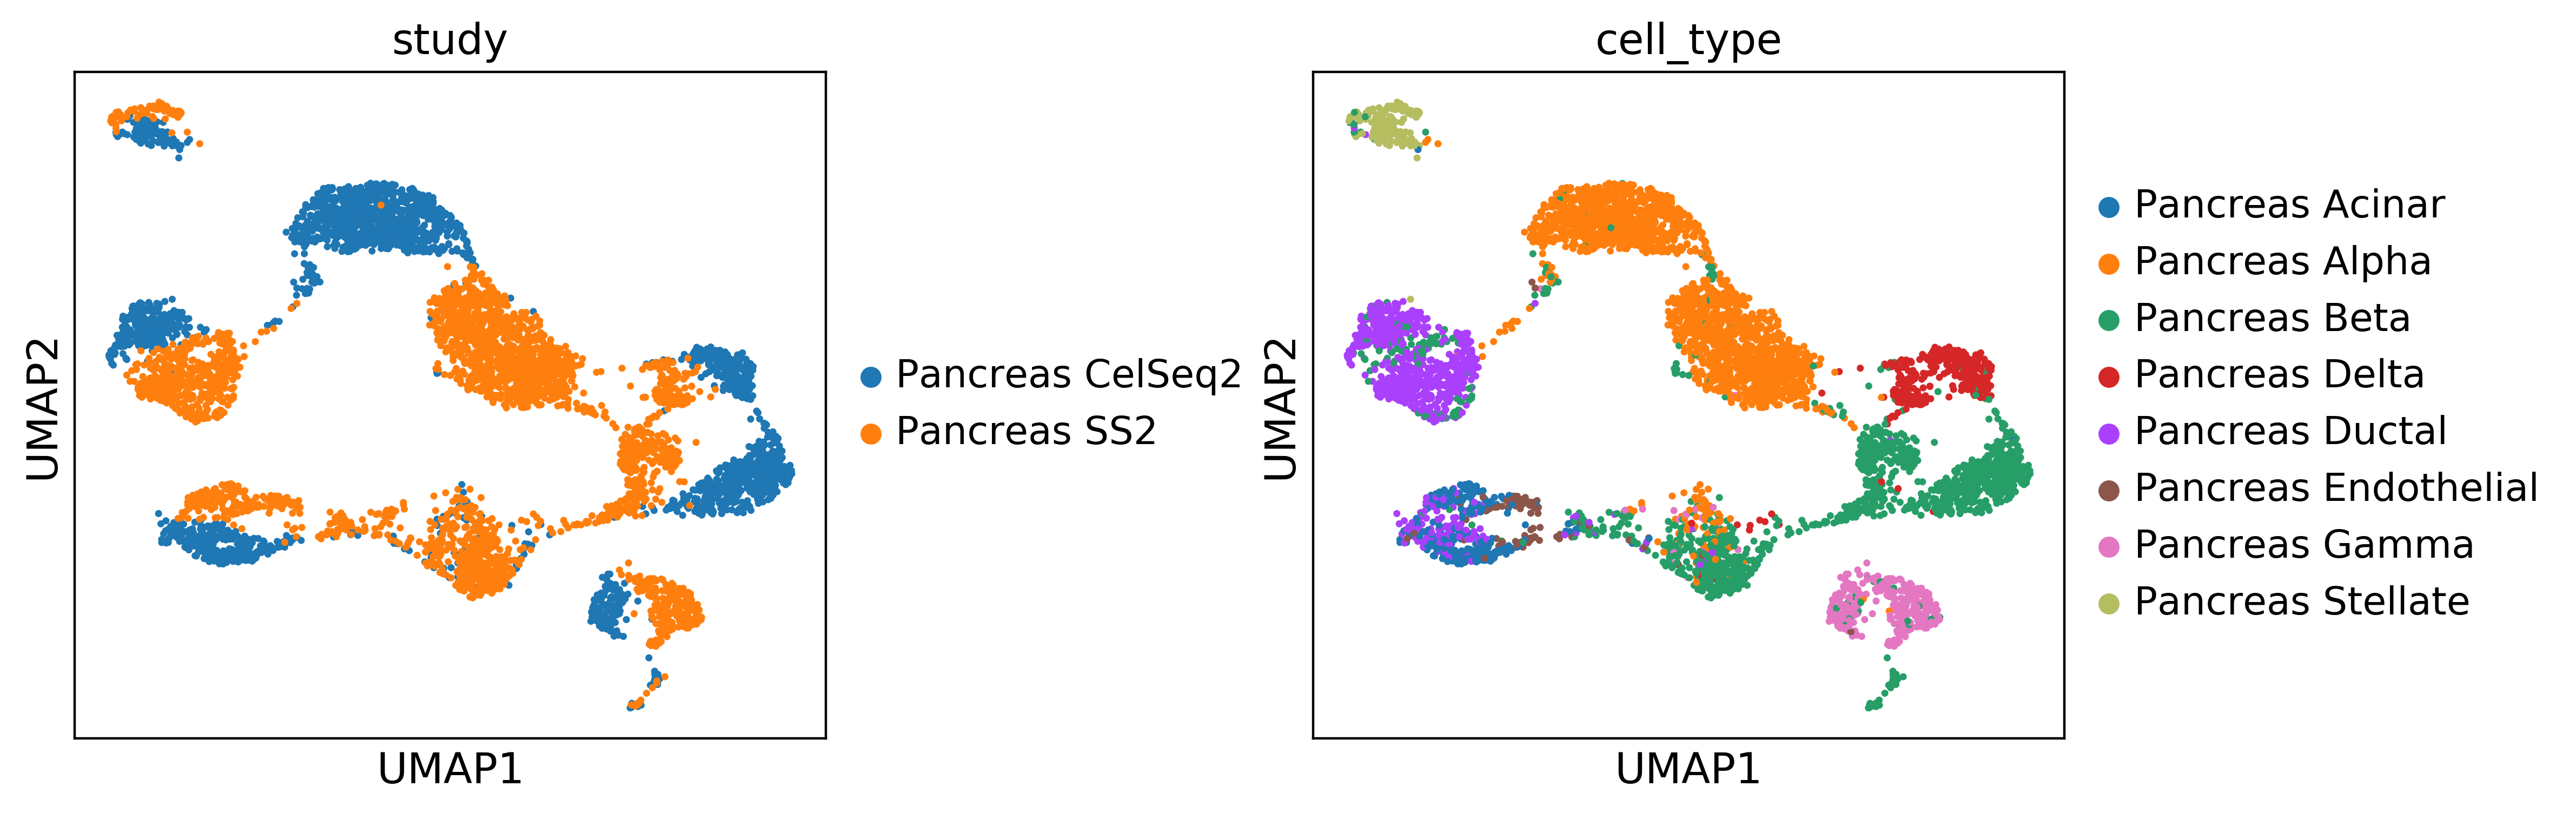

In [32]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [33]:
surgeon.metrics.ari(latent_adata, cell_type_key)

0.4995538513076697

In [34]:
surgeon.metrics.nmi(latent_adata, cell_type_key)

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.6467339841573809